# Image Classification

데이터를 ImageDataGenerator를 이용해 모델이 데이터를 효율적으로 활용할 수 있도록 구현해보는게 목적입니다.

* Data augmentation과 dropout을 이용해 오버피팅을 방지해봅시다.

기본적인 머신러닝 작업과정은 아래와 같습니다.

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

* 모델 완성 후 평가 지표에 따라서 모델을 평가해 봅시다.
* tensorflow 2.1 버전에 최적화되어있습니다.

## Project 설명
### Task
* 적은 수의 강아지와 고양이 사진을 이용해 classification을 진행해보자.
* 주어진 데이터를 Augmentation 하는 법과 딥러닝 트레이닝 과정을 구현해 보는것이 목표입니다.
* This code is borrowed from [TensorFlow tutorials/Image Segmentation](https://www.tensorflow.org/tutorials/images/classification).
* 데이터셋은 학습 데이터엔 강아지, 고양이 이미지 1000장이 있고, 테스트용 데이터에는 각각 500장씩 주어져있습니다.
    * 트레이닝 시 image size 조절해 사용

### Baseline
* 기본적으로 사용하는 Convulution layers를 구성해 사용해보자.
    * ex) Conv - Conv - pooling - FC layers
* 오버피팅을 방지하기 위한 다양한 방법들을 사용해보자.
* Training
    * Image generator 와 model.fit()을 사용
* Evaluation
    * 모델의 정확도와 크기를 이용해 점수를 제공하는 메트릭으로 평가해보자.

### Setting Tensorflow version

In [1]:
!pip install tensorflow-gpu==2.1

     |████████████████████████████████| 421.8MB 27kB/s 
     |████████████████████████████████| 3.9MB 52.5MB/s 
     |████████████████████████████████| 450kB 49.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=baac5dd90822840793410cc5a97021112b18229ba7732a577488f33246d454c1
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:

### Import packages

* 우리가 사용할 packages 를 import 하는 부분 입니다.
* 필요에 따른 packages를 선언합니다.
* 구글 드라이브를 마운트해줍니다.

In [0]:
use_colab = True
assert use_colab in [True, False]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
# 브럭처럼 쌓기 위해 Squential 사용
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

# Generator 를 활용해보자,
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [40]:
tf.__version__

'2.2.0'

### 데이터셋 다운로드

* 해당 데이터는 개와 고양이 데이터로 구성되어 있습니다.

In [0]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

### cats_and_dogs_filtered
* |__ train
    * |______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    * |______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
* |__ validation
    * |______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    * |______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]

# 데이터셋 설정
* 다운로드 받은 데이터셋에 대한 경로를 이용하여, 데이터를 이용할 준비를 진행합니다.

In [42]:
ls

cats/  dogs/  drive/


In [43]:
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

In [0]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [45]:
cd '/root/.keras/datasets/cats_and_dogs_filtered/train'

/root/.keras/datasets/cats_and_dogs_filtered/train


In [0]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  

* 데이터셋의 구성을 살펴봅시다.

In [47]:
# os.listdir : os.listdir를 사용하면 해당 디렉터리에 있는 파일들의 리스트를 구할 수 있다. 
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [48]:
cats_list

['/root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.591.jpg',
 '/root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.316.jpg',
 '/root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.116.jpg',
 '/root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.206.jpg',
 '/root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.908.jpg']

In [49]:
# 데이터 하나 찍어보기
# shape들이 모두 다르다,
from keras.preprocessing import image
cats_list = [train_cats_dir + '/' +os.listdir(train_cats_dir)[x] for x in range(5)]
for i in cats_list :  
  img = image.load_img(i)
  x = image.img_to_array(img)
  print(x.shape)

(499, 366, 3)
(283, 499, 3)
(375, 499, 3)
(500, 374, 3)
(337, 500, 3)


* 학습 데이터는 고양이와 강아지 이미지 각각 1000 장씩으로 구성되어있습니다.
* 모델 평가를 위해서 각각 500장씩을 validation dataset으로 사용합니다.

### 하이퍼파라미터 설정

* 모델 학습을 위한 하이퍼파라미터를 설정한다.
* 하이퍼파라미터는 학습에 중요한 역할을 하기 때문에 신중히 설정해야된다.

In [0]:
batch_size = 32 # 보통 2의 배수로 설정한다.
epochs = 50 #
IMG_HEIGHT = 150
IMG_WIDTH = 150

is_train = True
# the save point
if use_colab:
    checkpoint_dir ='./drive/My Drive/train_ckpt/classification/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = 'classification/exp1'

### Data preparation 데이터 준비

1. 저장된 images를 읽어온다.
2. RGB content 로 데이터를 디코드 한다.
3. floating point tensor로 변환한다.
4. 0 ~ 255 -> 0 ~ 1 값으로 rescale 한다.

* Data augmentation은 우리가 가진 데이터가 부족하기 때문에 데이터가 많은 것처럼 동작시키는 방법입니다.
* ImageDataGenerator 함수를 이용할 예정이며 해당 함수의 파라미터는 아래에서 확인할 수 있습니다.
* [함수 상세 보기](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [0]:
# 데이터셋에 저장된 이미지를 출력하는 함수
# 이미지 확인을 위해 사용한다.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
# Data Augmentation 작업
# Generator for our training data
image_gen_train = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [76]:
train_data_gen = image_gen_train.flow_from_directory(batch_size= batch_size,
                                                     directory= train_dir,
                                                     shuffle= True, # shuffle이 정확도에 영향을 미치는 이유? 1. ouverfitting 방지 1만 쭉쭉들어와 학습하다 갑자기 2가 들어오면 방향을 바꾸는것이 쉽지 않다.
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode= "binary")

# flow_from_directory는 이미지를 불러올 때 폴더명에 맞춰 자동으로 labelling을 해주기 때문입니다.

Found 2000 images belonging to 3 classes.


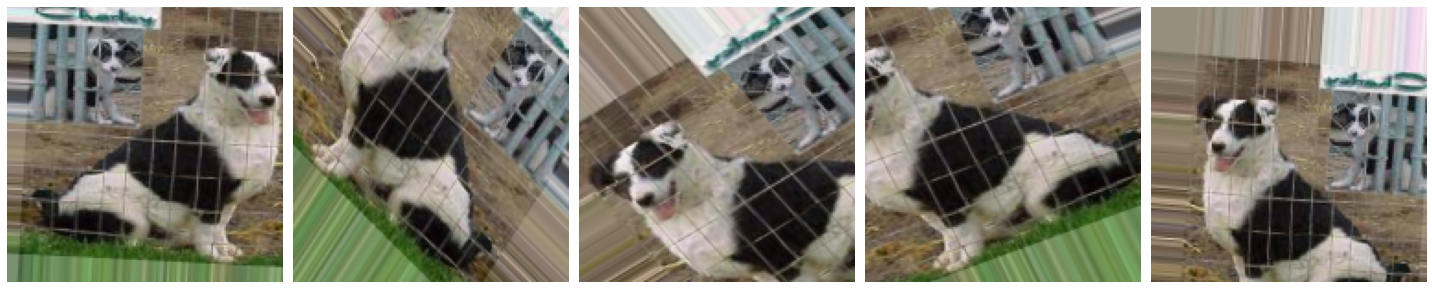

In [77]:
augmented_images = [train_data_gen[0][0][3] for i in range(5)]
plotImages(augmented_images)

In [78]:
train_data_gen

In [0]:
# Generator for our validation data
image_gen_val = ImageDataGenerator(rescale=1./255)

In [80]:
val_data_gen = image_gen_val.flow_from_directory(batch_size= batch_size,  
                                                 directory= validation_dir,
                                                 shuffle= True,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


### 이미지 샘플 확인

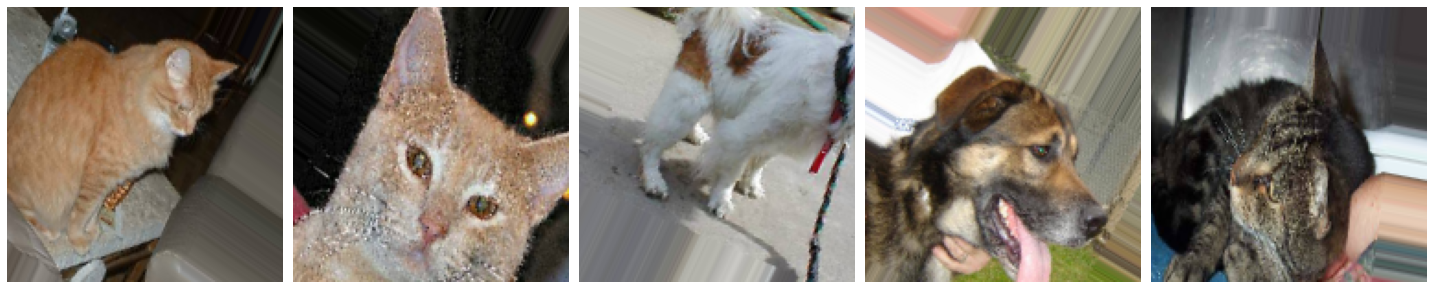

In [81]:
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:])

In [82]:
_[:5]

array([0., 0., 1., 1., 0.], dtype=float32)

In [83]:
sample_training_images.shape

(32, 150, 150, 3)

# 모델 제작

* 이미지 분류를 위한 모델을 제작합니다.
* Conv2D를 이용해 모델을 구성해봅시다.
* 분류 대상은 강아지와 고양이 2종류 입니다.

In [0]:
# 1차시도
# ex) Conv - Conv - pooling - FC layers

model = Sequential()
model.add(Conv2D(64, (3,3), padding='same', input_shape= (150, 150, 3)))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(128, (3,3), padding='same',  activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

### FC Layers 
model.add(Flatten())

# 64개의 Unit추가, activation은 relu
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

### Model compile

* 학습을 위한 optimizer, loss를 설정합니다.

In [0]:
# optimizer 추가
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.001)

model.compile(optimizer= optimizer,#,
              loss=tf.keras.losses.BinaryCrossentropy(),  # from_logits=True 가 무엇인가?
              # from_logits True 가 되어있으면 y값을 True 로 보내질 않는다.
              metrics=['accuracy'])

In [86]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
batch_normalization_4 (Batch (None, 150, 150, 64)      256       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 37, 37, 128)      

### checkpoints

In [0]:
if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

# 모델 학습 진행
* 학습을 진행할때, train과 valid 데이터셋을 이용하여 학습과 검증을 동시에 진행합니다.
* 각 데이터셋은 위에서 구성했기 때문에, 모델에서 사용할 데이터의 step의 길이를 batch_size를 이용해 계산해줍니다.

In [88]:
history = model.fit(
    train_data_gen,
    steps_per_epoch= total_train//batch_size,
    epochs= epochs,
    validation_data =val_data_gen,
    validation_steps= total_val//batch_size
)

Epoch 1/50
62/62 [==============================] - 16s 262ms/step - loss: 0.7983 - accuracy: 0.5198 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/50
62/62 [==============================] - 16s 262ms/step - loss: 0.6715 - accuracy: 0.5757 - val_loss: 0.6905 - val_accuracy: 0.5696
Epoch 3/50
62/62 [==============================] - 16s 261ms/step - loss: 0.6401 - accuracy: 0.6199 - val_loss: 0.6879 - val_accuracy: 0.5393
Epoch 4/50
62/62 [==============================] - 16s 259ms/step - loss: 0.6620 - accuracy: 0.5991 - val_loss: 0.6827 - val_accuracy: 0.5544
Epoch 5/50
62/62 [==============================] - 16s 261ms/step - loss: 0.6314 - accuracy: 0.6560 - val_loss: 0.6560 - val_accuracy: 0.6482
Epoch 6/50
62/62 [==============================] - 16s 259ms/step - loss: 0.6071 - accuracy: 0.6573 - val_loss: 0.6618 - val_accuracy: 0.5827
Epoch 7/50
62/62 [==============================] - 16s 260ms/step - loss: 0.6054 - accuracy: 0.6667 - val_loss: 0.6046 - val_accuracy: 0.6502

In [89]:
checkpoint.save(file_prefix = checkpoint_prefix)

'./drive/My Drive/train_ckpt/classification/exp1/ckpt-1'

# 학습 결과 확인

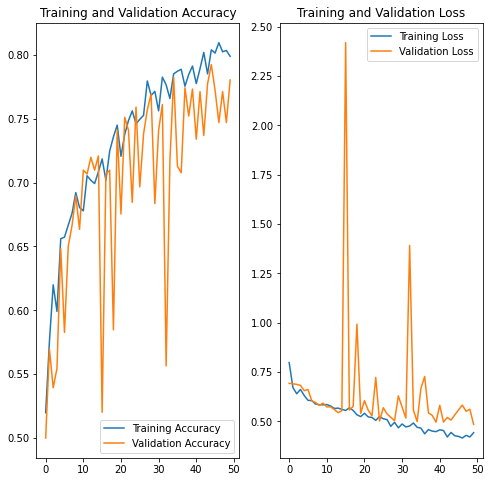

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Overfitting
* 만약 아래와 같은 그래프 학습 추이가 발생하는 경우 overfitting이 발생했다고 판단합니다.
* 이렇게되면 모델이 일반적인 환경에서 동작이 어렵게 됩니다.
* 이를 해결하는 방법인 Data augmentation, Dropout을 사용해 봅시다.

![Overfitting](https://www.tensorflow.org/tutorials/images/classification_files/output_K6oA77ADVrWp_0.png)

## Measuring final score
* 모델 평가 지표

### \begin{equation*} M = 50(P + min(\frac{1}{S}, 1)) \end{equation*}

* P : Model-accuracy
* S : Size of model (MB)

### \begin{equation*} S = \frac{Parameters * float_{size}}{MB} \end{equation*}
\begin{equation*} = \frac{M_p * 32} {1024^2} \end{equation*}


* 해당 지표는 분류 평가를 위한 내용이며, 모델의 크기에 따른 정확도를 나타내는 지표입니다.

In [91]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [92]:
eval = model.evaluate(val_data_gen)

32/32 [==============================] - 3s 80ms/step - loss: 0.4895 - accuracy: 0.7770


In [0]:
def final_score():
    print("Model params num : " + str(model.count_params()))
    print("Accuracy : " + str(eval[1]))

    s = (model.count_params() * 32) / (1024 ** 2)
    score = 50 * (eval[1] + min((1/s), 1))
    
    print("score : " + str(score))

In [94]:
final_score()

Model params num : 1735233
Accuracy : 0.7770000100135803
score : 39.79419646744544
